In [1]:
import numpy as np

In [2]:
# Define discrete 2D states S,S'
GRID_WORLD = np.zeros((5,5))

# Discount Factor
GAMMA = 0.9

GRID_WORLD

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [3]:
# Define Actions (A) --> North, South, East, West 
actions = [[-1,0], [1,0], [0,-1], [0,1]]

In [4]:
Q = np.zeros((GRID_WORLD.shape[0],GRID_WORLD.shape[1],len(actions)))

In [5]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

import time


class GridWorldEnv(gym.Env):
    def __init__(self):
        super(GridWorldEnv, self).__init__()
        
        # Define the grid size and observation space (5x5 grid)
        self.grid_size = 5
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size])
        
        # Define the action space (4 possible directions)
        self.action_space = spaces.Discrete(4)
        
        # Define the actions (up, down, left, right)
        self.actions = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])
        
        # Starting state and goal states
        self.state = self.observation_space.sample()
        self.goal_states = {
            (0, 1): (np.array([4, 1]), 10, True),  # Goal state 1 with reward +10 and termination
            (0, 3): (np.array([2, 3]), 5, True)    # Goal state 2 with reward +5 and termination
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        np.random.seed(int(time.time()))

        # Reset to the start state
        self.state = self.observation_space.sample()
        self.timestep = 0
        
        # Return initial observation
        return self.state, {}

    def step(self, action_idx):
        action = self.actions[action_idx]
        
        # Calculate new state (prime_state_id)
        prime_state_id = self.state + action
        termination = False
        
        # Check for out-of-bounds
        if (prime_state_id < 0).any() or (prime_state_id >= self.grid_size).any():
            reward_t = -1
            prime_state_id = self.state  # No movement if out of bounds
        # Check for special goal states
        elif tuple(self.state) in self.goal_states:
            prime_state_id, reward_t, termination = self.goal_states[tuple(self.state)]
        else:
            reward_t = -1  # Penalty for normal moves

        # Update the state
        self.state = prime_state_id.copy()
        
        self.timestep += 1
        
        if self.timestep>= 25:
            truncation = True
        else:
            truncation = False
        
        # Return the step information
        return self.state, reward_t, termination, truncation, {}

    def render(self):
        """Render the grid with the agent's current position."""
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'
        grid[tuple(self.state)] = 'A'  # Agent's current position
        for goal, (position, _, _) in self.goal_states.items():
            grid[tuple(position)] = 'G'
        
        print("\n".join(" ".join(row) for row in grid))
        print()


In [6]:
def epsilon_greedy(Q, epsilon = 0.7):
    epsilon_rnd = np.random.uniform()
    if epsilon_rnd < epsilon:
        argmax = np.argmax(Q)
        return actions[argmax], argmax
    else:
        rand_index = np.random.choice(np.array(actions).shape[0])
        return actions[rand_index], rand_index


In [7]:
def update_rule(Q, state_id,prime_state_id,action_idx, prime_action_idx,reward,termination, a = 0.03, gamma = 0.9):
    
    Q_sp_ap = Q[prime_state_id[0],prime_state_id[1],prime_action_idx]
    Q_s_a = Q[state_id[0],state_id[1],action_idx]
    
    Q_s_a =  Q_s_a + a*(reward + gamma*Q_sp_ap - Q_s_a)
    
    Q[state_id[0],state_id[1],action_idx] = Q_s_a
    
    return Q


In [8]:
# Iterative process, so we will run it for 10 times
# If this was some other higher dimensional, or continuous space, this would require a lot more iterations
# This number can range in the millions 

episodes = int(1e4)
timesteps = 25
termination = False
truncation = False


env = GridWorldEnv()


for episode in range(episodes):
       
    state_id = env.reset()[0]

    for timestep in range(timesteps):
        
        action, action_idx = epsilon_greedy(Q[state_id[0],state_id[1],:], 
                                            epsilon = 0.7)
        
        prime_state_id, reward, termination, truncation, _ = env.step(action_idx=action_idx)
        
        action_prime, prime_action_idx = epsilon_greedy(Q=Q[prime_state_id[0],
                                                            prime_state_id[1],:], 
                                                            epsilon=0.7)
        
        Q = update_rule(Q=Q,state_id=state_id,
                        prime_state_id=prime_state_id,
                        action_idx=action_idx,
                        prime_action_idx=prime_action_idx,
                        reward=reward,
                        termination = termination)
        
        state_id = np.array(prime_state_id)
        
        
        if termination or truncation:
            break
                        

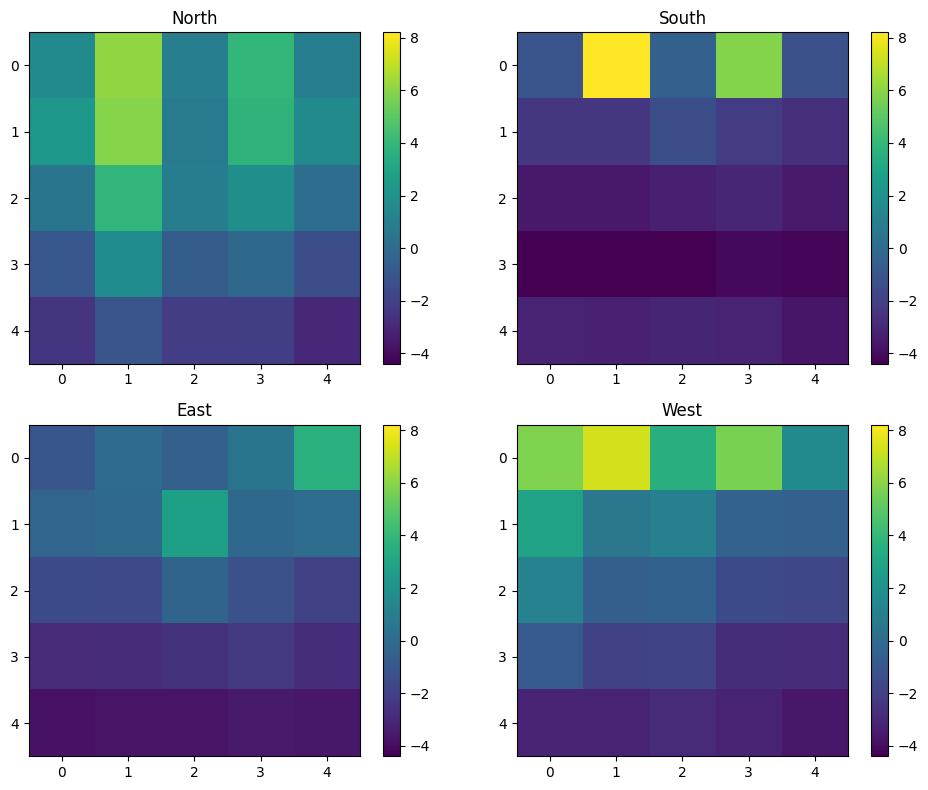

In [9]:
import matplotlib.pyplot as plt
import numpy as np

Q1 = Q[:, :, 0]
Q2 = Q[:, :, 1]
Q3 = Q[:, :, 2]
Q4 = Q[:, :, 3]

vmin = Q.min()
vmax = Q.max()

# Create subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# First subplot (top left)
im1 = axes[0, 0].imshow(Q1, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[0, 0].set_title("North")
plt.colorbar(im1, ax=axes[0, 0])

# Second subplot (top right)
im2 = axes[0, 1].imshow(Q2, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[0, 1].set_title("South")
plt.colorbar(im2, ax=axes[0, 1])

# Third subplot (bottom left)
im3 = axes[1, 0].imshow(Q3, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[1, 0].set_title("East")
plt.colorbar(im3, ax=axes[1, 0])

# Fourth subplot (bottom right)
im4 = axes[1, 1].imshow(Q4, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[1, 1].set_title("West")
plt.colorbar(im4, ax=axes[1, 1])

# Display the plot
plt.tight_layout()
plt.show()


In [10]:
episodes = int(1)
timesteps = 25
termination = False
truncation = False

for episode in range(episodes):
    
    state_id = env.reset()[0]
   
    plot_states = []
    plot_states.append(state_id)

    
    for i, timestep in enumerate(range(timesteps)):
        
        action, action_idx = epsilon_greedy(Q[state_id[0],state_id[1],:], 
                                            epsilon = 1)
        
        prime_state_id, reward, termination, truncation, _ = env.step(action_idx=action_idx)
                
        state_id = np.array(prime_state_id)
        plot_states.append(state_id)

        
        if i == timesteps-1:
            truncation = False

        
        if termination or truncation:
            print("Total timesteps: ", i)
            print("Final reward: ", reward)

            break
        

Total timesteps:  4
Final reward:  10


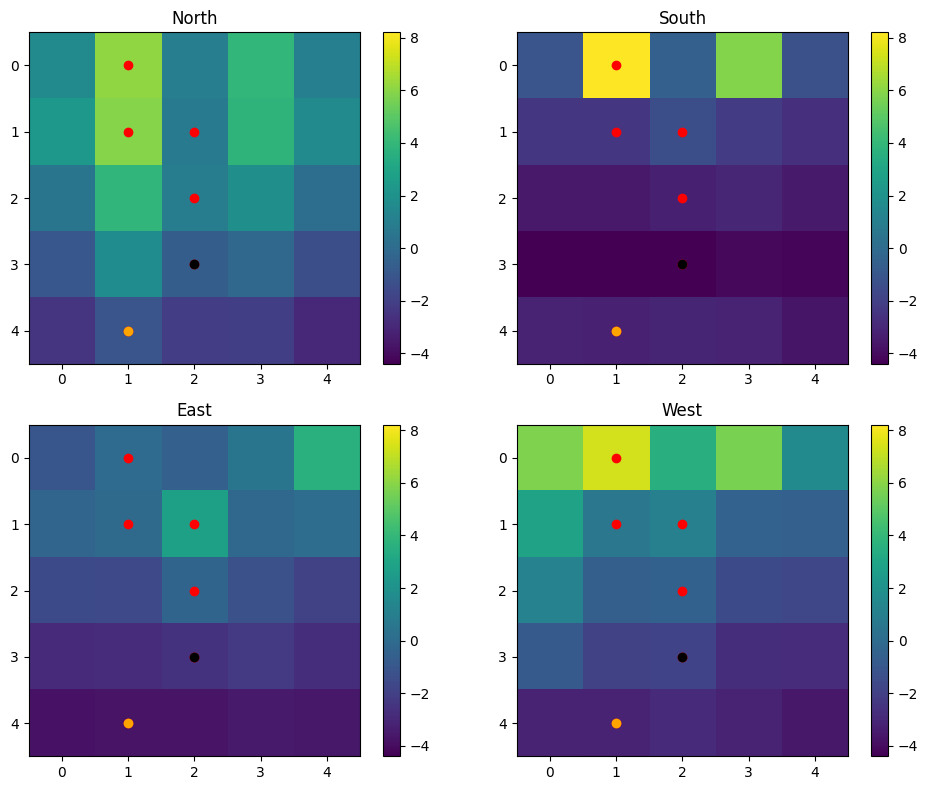

In [11]:
import matplotlib.pyplot as plt
import numpy as np

Q1 = Q[:, :, 0]
Q2 = Q[:, :, 1]
Q3 = Q[:, :, 2]
Q4 = Q[:, :, 3]

plot_states = np.array(plot_states)

vmin = Q.min()
vmax = Q.max()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

im1 = axes[0, 0].imshow(Q1, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[0, 0].set_title("North")
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(Q2, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[0, 1].set_title("South")
plt.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 0].imshow(Q3, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[1, 0].set_title("East")
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(Q4, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[1, 1].set_title("West")
plt.colorbar(im4, ax=axes[1, 1])


axes = axes.flatten()

for ax in axes:
    ax.scatter(x=plot_states[:, 1], y=plot_states[:, 0], color="red")  # Scatter all points in red
    ax.scatter(x=plot_states[0, 1], y=plot_states[0, 0], color="black")  # Single black point
    ax.scatter(x=plot_states[-1, 1], y=plot_states[-1, 0], color="orange")  # Single black point


# Display the plot
plt.tight_layout()
plt.show()
